### Data augmentation of character images for training of classification model

In [26]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import random

from matplotlib import pyplot as plt
import seaborn as sns

import imgaug as ia
import imgaug.augmenters as iaa
from skimage.transform import swirl

from torchvision.io import read_image

from PIL import Image

from pathlib import Path

import shutil

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
# INPUT_FOLDER = r'/content/IAM-data'
INPUT_FOLDER = r'/home/hkolstee/uniprojects/DATA/HWR/IAM-data/IAM-data'
OUTPUT_FOLDER = INPUT_FOLDER + "_augm"

In [29]:
# check if input dir exists
if os.path.isdir(INPUT_FOLDER):
    # create output folder, delete if already exists
    shutil.rmtree(OUTPUT_FOLDER, ignore_errors=True)
    os.mkdir(OUTPUT_FOLDER)
        

In [30]:
raw_data = pd.read_fwf(os.path.join(INPUT_FOLDER, "iam_lines_gt.txt"), header = None)
raw_data = raw_data.values.tolist()
print(len(raw_data))

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

14916


,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


## Data augmentation   
We will be using the package **imgaug**.   
Data is still ***img_data*** and ***class_name***.

### Augmentations:
- Rotate
- Scale
- Gaussian noise
- Shear (X/Y)
- Translate (X/Y)
- Swirl
- Elastic transform
- Random erase


In [82]:
def rotate_image(input_img, rotation):
    rot = iaa.Affine(rotate = rotation)
    rotated_img = rot.augment_image(input_img)
    return rotated_img

def scale_image(input_img, percent):
    scale = iaa.Affine(scale = percent)
    scaled_img = scale.augment_image(input_img)
    return scaled_img

def gaussian_noise(input_img, std_of_normal):
    noise = iaa.AdditiveGaussianNoise(scale = std_of_normal)
    noisy_img = noise.augment_image(input_img)
    return noisy_img

def shearX_image(input_img, degree):
    shear = iaa.ShearX(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def shearY_image(input_img, degree):
    shear = iaa.ShearY(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def translateX(input_img, percent):
    tX = iaa.TranslateX(percent = percent)
    tX_img = tX.augment_image(input_img)
    return tX_img

def translateY(input_img, percent):
    tY = iaa.TranslateY(percent = percent)
    tY_img = tY.augment_image(input_img)
    return tY_img

def swirl_image(input_img, rotation, strength, radius):
    swirled_img = swirl(input_img, rotation = rotation, strength = strength, radius = radius)
    return swirled_img

def elastic_transform(input_img, alpha, sigma):
    elastic = iaa.ElasticTransformation(alpha = alpha, sigma = sigma, mode = "nearest")
    elastic_img = elastic.augment_image(input_img)
    return elastic_img

# randomly erases a block of about 10% of the image
def random_erase(input_img):
    # create output img
    output_img = np.copy(input_img)
    
    for i in range(2):
        # get x and y coords
        randomX1 = random.uniform(0., 0.7)
        randomX2 = random.uniform(randomX1+0.075, 1.0)
        randomY1 = random.uniform(0., 0.7)
        randomY2 = (0.1125 / (abs(randomX1 - randomX2))) + randomY1

        # loop over pixels to erase
        for i in range(round(randomX1*27), round(randomX2*27)):
            for j in range(round(randomY1*27), min(round(randomY2*27), 28)):
                output_img[i][j] = 0.
    
    return output_img

In [32]:
def random_augment(input_img, nr_of_augments):
    # list of functions
    functions = [lambda x : rotate_image(x, -15), lambda x : rotate_image(x, 15), lambda x : scale_image(x, 0.8), lambda x : scale_image(x, 1.2), 
                lambda x : gaussian_noise(x, 0.075), lambda x : shearX_image(x, 30), lambda x : shearX_image(x, -30), 
                lambda x : shearY_image(x, 30), lambda x : shearY_image(x, -30), lambda x : translateX(x, 0.1), 
                lambda x : translateX(x, -0.1), lambda x : translateY(x, 0.1), lambda x : translateY(x, -0.1), 
                lambda x : swirl_image(x, rotation = -0.15, strength = -1, radius = 30), 
                lambda x : swirl_image(x, rotation = 0.15, strength = 1, radius = 30), lambda x : random_erase(x),
                lambda x : elastic_transform(x, 50, 8)]
    
    # copy input img
    output_img = np.copy(input_img)
    # apply augments
    for i in range(nr_of_augments):
        output_img = random.choice(functions)(output_img)
        
    return output_img    

In [33]:
def display_images(image_list, title):
    nr_images = len(image_list)
    
    # size of x axis in grid
    x = int(np.floor(np.sqrt(nr_images)))
    # size of y axis in grid
    y = int(np.ceil(nr_images/x))
    
    fig, axs = plt.subplots(x, y)
    axs = axs.flatten()
    for (image, ax) in zip(image_list, axs):
        ax.imshow(image, cmap = "Greys")
    
    fig.suptitle(title)
    plt.show()

(142, 1761)


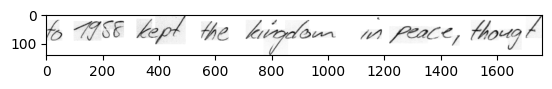

In [72]:
# we will be using image 1000 to showcase the augmentations
input_img = read_image(os.path.join(INPUT_FOLDER, "img", data["img_names"][1])).numpy()
input_img = input_img.squeeze()

print(input_img.shape)
plt.imshow(input_img, cmap = "gray")


1


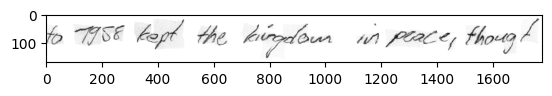

In [320]:

# plt.imshow(input_img, cmap = "gray")
# print(elastic_transform_img)
i = np.random.randint(0, 2)
print(i)
if i == 0:
    image = np.pad(input_img, ((np.random.randint(0, 30), np.random.randint(0, 30)), (np.random.randint(0, 250), 0)), constant_values = 255)
else:
    image = np.pad(input_img, ((np.random.randint(0, 30), np.random.randint(0, 30)), (0, np.random.randint(0, 250))), constant_values = 255)

#  = np.pad(input_img, ((np.random.randint(0, 30), np.random.randint(0, 30)), (np.random.randint(0, 250), np.random.randint(0, 250))), constant_values = 255)
elastic_transform_img = elastic_transform(image, 300, 20)
# elastic_transform_img = translateX(elastic_transform_img)
plt.imshow(elastic_transform_img, cmap = "gray")


In [ ]:
# regular_augment_imgs = []
# elastic_imgs = []
# random_erase_imgs = []
# random_augments_imgs = []

# augmentations
# rotated_img1 = rotate_image(input_img, -15)
# rotated_img2 = rotate_image(input_img, 15)
# scaled_img1 = scale_image(input_img, 0.8)
# scaled_img2 = scale_image(input_img, 1.2)
# gaussian_noise_img = gaussian_noise(input_img, 0.05)
# shearedX_img1 = shearX_image(input_img, 15)
# shearedX_img2 = shearX_image(input_img, -15)
# shearedY_img1 = shearY_image(input_img, 15)
# shearedY_img2 = shearY_image(input_img, -15)
translateX_img1 = translateX(input_img, 0.1)
# translateX_img2 = translateX(input_img, -0.1)
# translateY_img1 = translateY(input_img, 0.1)
# translateY_img2 = translateY(input_img, -0.1)
# swirled_image1 = swirl_image(input_img, rotation = -0.15, strength = -1, radius = 30)
# swirled_image2 = swirl_image(input_img, rotation = 0.15, strength = 1, radius = 30)

# # append and display
# regular_augment_imgs.append(input_img)
# regular_augment_imgs.append(rotated_img1)
# regular_augment_imgs.append(rotated_img2)
# regular_augment_imgs.append(scaled_img1)
# regular_augment_imgs.append(scaled_img2)
# regular_augment_imgs.append(gaussian_noise_img)
# regular_augment_imgs.append(shearedX_img1)
# regular_augment_imgs.append(shearedX_img2)
# regular_augment_imgs.append(shearedY_img1)
# regular_augment_imgs.append(shearedY_img2)
# regular_augment_imgs.append(translateY_img1)
# regular_augment_imgs.append(translateY_img2)
# regular_augment_imgs.append(translateX_img1)
# regular_augment_imgs.append(translateX_img2)
# regular_augment_imgs.append(swirled_image1)
# regular_augment_imgs.append(swirled_image2)
# display_images(regular_augment_imgs, "Regular augmentations")

# # showcase elastic transformation
# for i in range(20):
#     image = elastic_transform(input_img, 50, 8)
#     elastic_imgs.append(image)
# display_images(elastic_imgs, "Elastic transformation")

# # showcase random erase
# for i in range(20):
#     image = random_erase(input_img)
#     random_erase_imgs.append(image)
# display_images(random_erase_imgs, "Random erasing")

# # showcase 3 random augments in succession
# for i in range(20):
#     image = random_augment(input_img, 2)
#     random_augments_imgs.append(image)
# display_images(random_augments_imgs, "2 random succeeding augments")

## Transform the dataset

### Check inbalance

In [14]:
classes, counts = np.unique(train_y, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value
    
print(f"Unique classes and number of images in train set:")
data_dict

Unique classes and number of images in train set:


{'Alef': 242,
 'Ayin': 228,
 'Bet': 240,
 'Dalet': 74,
 'Gimel': 230,
 'He': 243,
 'Het': 242,
 'Kaf': 152,
 'Kaf-final': 6,
 'Lamed': 240,
 'Mem': 231,
 'Mem-medial': 245,
 'Nun-final': 106,
 'Nun-medial': 236,
 'Pe': 27,
 'Pe-final': 10,
 'Qof': 202,
 'Resh': 67,
 'Samekh': 248,
 'Shin': 226,
 'Taw': 246,
 'Tet': 246,
 'Tsadi-final': 58,
 'Tsadi-medial': 242,
 'Waw': 91,
 'Yod': 18,
 'Zayin': 7}

### Add all images to new augmented directory

In [15]:
# image array and class name
# img_data, class_names = create_dataset(INPUT_FOLDER)

In [16]:
def saveImgs(imgs, labels, subdir):
    # make subdir
    if not os.path.isdir(os.path.join(OUTPUT_FOLDER, subdir)):
        os.mkdir(os.path.join(OUTPUT_FOLDER, subdir))
    
    # train (this could maybe be in function)
    for idx, (img, class_name) in enumerate(zip(imgs, labels)):
        # check if folder exists
        if not os.path.isdir(os.path.join(OUTPUT_FOLDER, subdir, class_name)):
            # create folder
            os.mkdir(os.path.join(OUTPUT_FOLDER, subdir, class_name))
            # os.mkdir(os.path.join(OUTPUT_FOLDER, subdir, class_name))
        
        # add all original images to augmented directories
        # invert
        img = 1 - img
        img *= 255
        img = img.astype("int32")
        image = Image.fromarray(img)
        image = image.convert("L")
        image.save(os.path.join(OUTPUT_FOLDER, subdir, class_name, class_name + str(idx) + ".jpg"))

In [17]:
saveImgs(train_x, train_y, "train")
saveImgs(test_x, test_y, "test")

## Use ***elastic transform*** to add 150 images, then add 150 ***random erase*** chars

In [18]:
for class_dir in os.listdir(os.path.join(OUTPUT_FOLDER, "train")):
    # print(class_dir)
    # determine how many images per class directory
    # nr_of_files = len([name for name in os.listdir(os.path.join(OUTPUT_FOLDER, "train", class_dir)) if os.path.isfile(os.path.join(OUTPUT_FOLDER, "train", class_dir, name))])
    # print(nr_of_files)
    
    # fill to 300 with elastic transforms
    # if (nr_of_files < 300):
    img_buffer = []
    # print(300 - nr_of_files)
    
    # add elastic transform
    for i in range(100):
        # print(class_dir, i)
        # select random file out of 300
        image_filename = random.choice(os.listdir(os.path.join(OUTPUT_FOLDER, "train", class_dir)))
        image = cv2.imread(os.path.join(OUTPUT_FOLDER, "train", class_dir, image_filename), -1)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
        # # if image is not grayscale
        if (image.shape != (IMG_WIDTH, IMG_HEIGHT)):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # invert
        image = cv2.bitwise_not(image)
        image = np.array(image)
        
        # transform img
        transformed_img = elastic_transform(image, 50, 8)
        # invert after transform to prevent black border due to transform
        transformed_img = cv2.bitwise_not(transformed_img)

        # save transformed img
        transformed_img = Image.fromarray(transformed_img)
        # add img and file_name to buffer to not sample from transformed imgs
        img_buffer.append((transformed_img, os.path.join(OUTPUT_FOLDER, "train", class_dir, Path(image_filename).stem + str(i) + ".jpg")))
        
    # add elastic transform
    for i in range(100):
        # select random file
        image_filename = random.choice(os.listdir(os.path.join(OUTPUT_FOLDER, "train", class_dir)))
        image = cv2.imread(os.path.join(OUTPUT_FOLDER, "train", class_dir, image_filename), -1)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
        # # if image is not grayscale
        if (image.shape != (IMG_WIDTH, IMG_HEIGHT)):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # invert
        image = cv2.bitwise_not(image)
        image = np.array(image)
        
        # transform img
        transformed_img = random_erase(image)
        # invert after transform to prevent black border due to transform
        transformed_img = cv2.bitwise_not(transformed_img)

        # save transformed img
        transformed_img = Image.fromarray(transformed_img)
        # add img and file_name to buffer to not sample from transformed imgs
        img_buffer.append((transformed_img, os.path.join(OUTPUT_FOLDER, "train", class_dir, Path(image_filename).stem + str(i) + ".jpg")))
    
    # add all transformed images in buffer to directory
    # print(img_buffer)
    for img, file_name in img_buffer:
        # print(img.shape, file_name)
        img.save(file_name)

### Check balance

In [19]:
# image array and class name
img_data, class_names = create_dataset(os.path.join(OUTPUT_FOLDER, "train"))
# get number of uniques
classes, counts = np.unique(class_names, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value

print(f"Unique classes and number of images:")
data_dict

Unique classes and number of images:


{'Alef': 441,
 'Ayin': 428,
 'Bet': 440,
 'Dalet': 272,
 'Gimel': 430,
 'He': 443,
 'Het': 441,
 'Kaf': 352,
 'Kaf-final': 187,
 'Lamed': 440,
 'Mem': 431,
 'Mem-medial': 445,
 'Nun-final': 306,
 'Nun-medial': 433,
 'Pe': 225,
 'Pe-final': 204,
 'Qof': 402,
 'Resh': 266,
 'Samekh': 446,
 'Shin': 425,
 'Taw': 446,
 'Tet': 445,
 'Tsadi-final': 258,
 'Tsadi-medial': 442,
 'Waw': 288,
 'Yod': 211,
 'Zayin': 190}

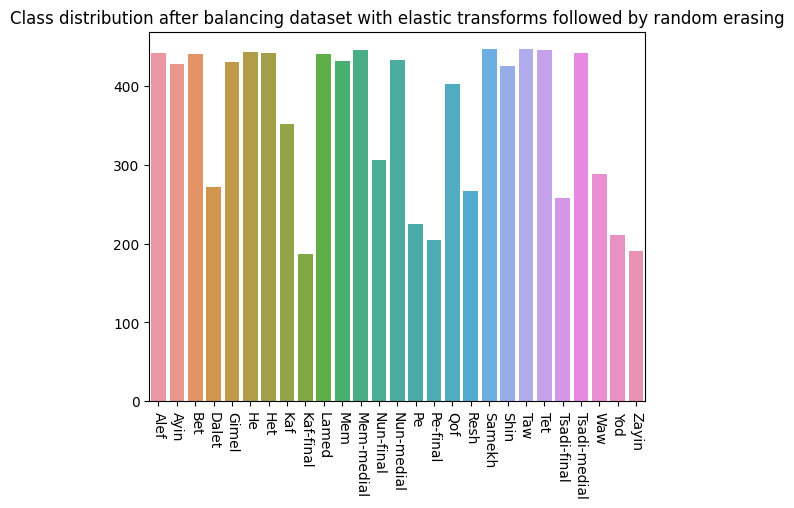

In [20]:
df = pd.DataFrame(data_dict, index=[0])
fig = sns.barplot(df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90, horizontalalignment='center')
fig.set(title="Class distribution after balancing dataset with elastic transforms followed by random erasing")
plt.show()